# Рекомендация тарифов

## Описание проекта

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».
В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — она уже сделана.

## Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.
- сalls — количество звонков
- minutes — суммарная длительность звонков в минутах
- messages — количество sms-сообщений
- mb_used — израсходованный интернет-тафик в Мб
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)

## Ход работы

1) Изучение данных
2) Разделение данных на обучающую, валидационную и тестовую выборки
3) Применение разных моделей, изучение их качества
4) Выбор подходящей модели
5) Проверка качества модели на тестовой выборке
6) Проверка модели на вменяемость
7) Вывод

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

import pandas as pd
import time as tm

## Получение и изучение данных

Получим данные и изучим их. Для этого выведем первые строки датафрейма, основную информацию о данных и построим распределение данных.

In [ ]:
try:
    df = pd.read_csv('C:\\Users\\Ксения\\Downloads\\users_behavior.csv')
except:
    df = pd.read_csv('/datasets/users_behavior.csv')

In [ ]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


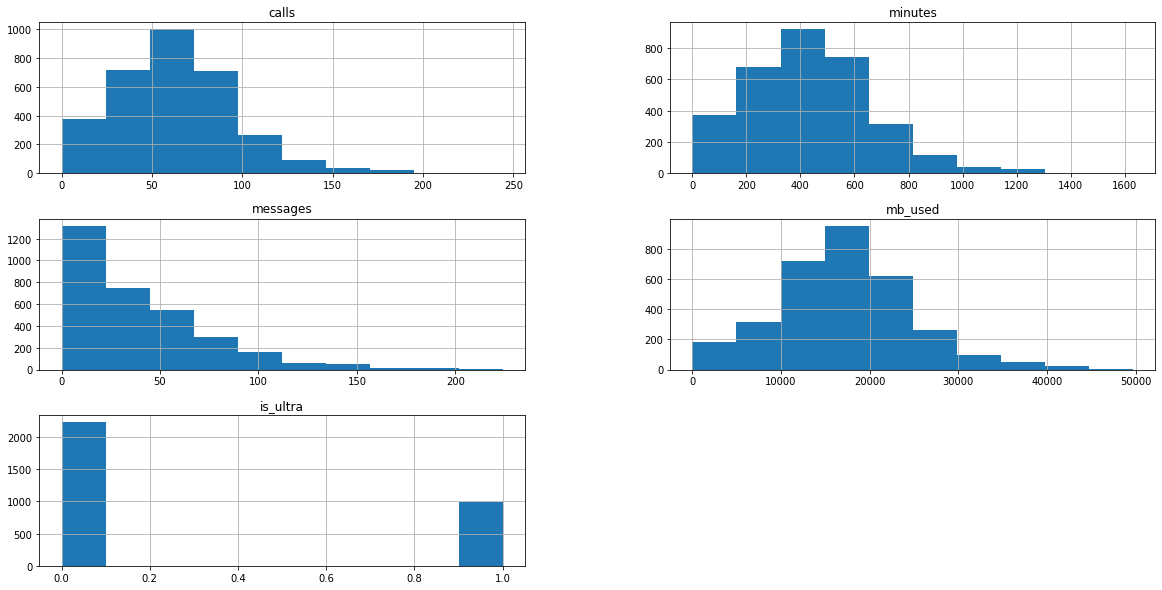

In [ ]:
df.hist(bins=10, figsize=(20, 10));

Вывод:

Убедимся, что предобработка не требуется. Пропусков в данных нет, выбросов и аномальных значений нет, распределения соответствуют теоретически ожидаемым.

## Разделение данных на обучающую, валидационную и тестовую выборки

Перед разделением данных необходимо их подготовить, выделив признаки и целеворй признак в разные переменные.

Затем разделим данные в cоотношении 3/1/1. Для этого выделим 20% исходных данных в тестовую выборку и 25% от оставшихся данных в валидационную выборку.

In [ ]:
#подготовка данных
def data_preparation(df, target_feature, proportions=(3, 1, 1)):
    #нормировка данных
    df = (df-df.min())/ (df.max() - df.min())

    #выделение целевого признака
    test_percent = (100 / sum(proportions)) * proportions[2]
    valid_percent = (100 / (100 - test_percent)) * (100 / sum(proportions)) * proportions[1]
    features = df.drop(target_feature, axis=1)
    target = df.loc[:, target_feature]

    #рвзделение данных на выборки
    features_train_valid, features_test, target_train_valid,  target_test = train_test_split(
        features,
        target,
        test_size=(test_percent / 100),
        random_state=12345,
        stratify=target)
    features_train, features_valid, target_train,  target_valid = train_test_split(
        features_train_valid,
        target_train_valid,
        test_size=(valid_percent / 100),
        random_state=12345,
        stratify=target_train_valid)

    return features_train, target_train, features_valid, target_valid, features_test,  target_test

In [ ]:
features_train, target_train, features_valid, target_valid, features_test,  target_test = data_preparation(df, 'is_ultra')

In [ ]:
print(
    features_train.shape, target_train.shape, '\n',
    features_valid.shape, target_valid.shape, '\n',
    features_test.shape, target_test.shape)

(1928, 4) (1928,) 
 (643, 4) (643,) 
 (643, 4) (643,)


In [ ]:
print('Соотношение выборок: {0}:{1}:{2}'.format(
    round(features_train.shape[0]/features_valid.shape[0]),
    round(features_valid.shape[0]/features_test.shape[0]),
    round(features_valid.shape[0]/features_test.shape[0])))

Соотношение выборок: 3:1:1


Вывод:

В ходе данного пункта мы написали функцию для подготовки данных, а затем убедились, что размерности полученных выборок соответствуют заданному соотношению.

## Применение разных моделей, изучение их качества

In [ ]:
model_name = []
model_acc = []
model_time = []

### Решающее дерево

Изучение качества моделей начнем с решающего дерева. Для подбора оптимального значения глубины дерева рассчитаем значения точности модели для всех значений глубин от 1 до 10 и выберем глубину с максимальной точностью, рассчитанной по валидационной выборке.

In [ ]:
best_tree_model = 0
best_tree_accuracy = 0
best_tree_depth = 0
best_leaves_n = 0
best_samples = 0
time = 0

for samples in range(1, 6):
    for leaves_n in range(10, 50):
        for depth in range(1, 11):
            model = DecisionTreeClassifier(max_depth=depth, max_leaf_nodes=leaves_n, min_samples_leaf=samples, random_state=12345)
            start = tm.time()
            model.fit(features_train, target_train)
            end = tm.time()
            predictions_valid = model.predict(features_valid)
            accuracy = accuracy_score(target_valid, predictions_valid)
            if accuracy > best_tree_accuracy:
                best_tree_model = model
                best_tree_accuracy = accuracy
                best_tree_depth = depth
                best_leaves_n = leaves_n
                best_samples = samples
                time = end - start

model_name.append('Дерево решений')
model_acc.append(best_tree_accuracy)
model_time.append(time)
print('Для лучшей модели показатель точности = {0}, махсимальная глубина = {1}, кол-во листьев = {2}, кол-во экземпляров в листе {3}'
      .format(best_tree_accuracy, best_tree_depth, best_leaves_n, best_samples))

Для лучшей модели показатель точности = 0.8227060653188181, махсимальная глубина = 7, кол-во листьев = 36, кол-во экземпляров в листе 4


### Случайный лес

Теперь перейдем к алгоритму классификации случайный лес. Для модели случайного леса будем подбирать сразу 2 гиперпараметра: глубина каждого дерева и количество этих деревьев. Найдем такие значения этих гиперпараметров, чтобы показатель точности был максимальным.

In [ ]:
best_forest_model = 0
best_forest_accuracy = 0
best_forest_depth = 0
best_forest_estimators = 0

for estimators in range(1, 16):
    for depth in range(1, 16):
        model = RandomForestClassifier(max_depth=depth, n_estimators=estimators, random_state=12345)
        start = tm.time()
        model.fit(features_train, target_train)
        end = tm.time()
        predictions_valid = model.predict(features_valid)
        accuracy = accuracy_score(target_valid, predictions_valid)
        if accuracy > best_forest_accuracy:
            best_forest_model = model
            best_forest_accuracy = accuracy
            best_forest_depth = depth
            best_forest_estimators = estimators
            time = end - start

model_name.append('Случайный лес')
model_acc.append(best_forest_accuracy)
model_time.append(time)
print('Для лучшей модели показатель точности = {0}, махсимальная глубина = {1}, количество деревьев = {2}'
      .format(best_forest_accuracy, best_forest_depth, best_forest_estimators))

Для лучшей модели показатель точности = 0.833592534992224, махсимальная глубина = 8, количество деревьев = 10


### Логистическая регрессия

Теперь перейдем к алгоритму классификации логистическая регрессия.

In [ ]:
best_log_model = 0
best_log_accuracy = 0
best_log_iter = 0

for iteration in range(1, 10):
    model = LogisticRegression(solver='lbfgs', max_iter=iteration, random_state=12345)
    start = tm.time()
    model.fit(features_train, target_train)
    end = tm.time()
    predictions_valid = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions_valid)
    if accuracy > best_log_accuracy:
            best_log_model = model
            best_log_accuracy = accuracy
            best_log_iter = iteration
            time = end - start

model_name.append('Логистическая регрессия')
model_acc.append(best_log_accuracy)
model_time.append(time)
print('Для модели показатель точности = {0}, количество итераций = {1}'
      .format(best_log_accuracy, best_log_iter))

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Для модели показатель точности = 0.749611197511664, количество итераций = 6


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Как видим, в результате выполнения алгоритма появляется предупреждение о сходимости алгоритма, то есть о том, что ошибка решения изменяется в очень малом диапазоне, а следовательно увеличение количства итераций не приведет к существенному увеличению точности.

### Сравнение моделей

Для сравнения моделей создадим список с их показателями точности и временем выполнения.

In [ ]:
model_comparison = pd.DataFrame(data={'model_name': model_name, 'accuracy': model_acc, 'execution_time': model_time})
model_comparison

,model_name,accuracy,execution_time
0,Дерево решений,0.822706,0.006042
1,Случайный лес,0.833593,0.202526
2,Логистическая регрессия,0.749611,0.088981


Вывод:

Как видим, максимальная точность соответствует модели случаный лес, поэтому ее и будем использовать затем для проверки на тестовой выборке.

Большая точность модели случаного леса по сравнению с решающим деревом объясняется тем, что данная модель по сути составляет несколько решающих деревьев, результаты вычислений которых усредняются. Большим количеством вычислений объясняется и на порядок большое время вычислений.

Точность логистической регрессии оказалась наименьшей, но при этом и время вычислений также является наименьшим.

## Проверка качества модели на тестовой выборке

Теперь проверим качество модели на тестовой выборке.

In [ ]:
model = best_forest_model
model

RandomForestClassifier(max_depth=8, n_estimators=10, random_state=12345)

In [ ]:
predictions_test = model.predict(features_test)
accuracy = accuracy_score(target_test, predictions_test)
print('Показатель точности модели: ', round(accuracy, 5))

Показатель точности модели:  0.80871


Вывод:

В результате проверки модели на тестовой выборке мы получили показатель точности примерно 0.81, то есть примерно в 81% случав модель верно классифицирует объект.

## Проверка модели на вменяемость

В завершение проверим модель на вменяемость. Для этого воспользуемся константной моделью, предсказания которой не зависят от признаков объекта. Для обучения используем обучающую выборку, а для оценки качества сразу тестовую, чтобы сравнить полученный показатель с результатми работы выбранной нами модели.

In [ ]:
model = DummyClassifier(strategy='most_frequent')
model.fit(features_train, target_train)
predictions = model.predict(features_test)
accuracy = accuracy_score(target_test, predictions)
print('Показатель точности модели: ', round(accuracy, 5))

Показатель точности модели:  0.69362


Вывод:

Полученный показатель точности для константной модели меньше показателя точности для нашей модели.

## Вывод

В ходе данной работы нами были получены данные, затем они были проверены, из чего нами был сделан вывод об отсутствии необходимости в их предобработку.

Затем на имеющихся данных были обучены три модели из которых по показателю точности была выбрана наилучшая модель. Ее точность предсказания для тестовой выборки достигает 81%.

Для того, чтобы убедиться в правильности работы модели мыл проведен тест на ее вменяемость, в ходе которого оказалось, что ее точность превышает точноть константной модели.